In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

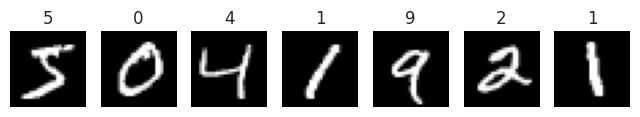

In [2]:
DATA_DIR = '../data'

# Download the datasets

train_dataset = datasets.MNIST(
    root=DATA_DIR,
    download=True,
    train=True,
    transform=ToTensor(),
)

test_dataset = datasets.MNIST( 
    root=DATA_DIR,
    download=True,
    train=False,
    transform=ToTensor(),
)

batch_size = 64 

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Visualize the dataset
fig, ax = plt.subplots(1, 7)
for i in range(7):
    ax[i].imshow(train_dataset[i][0].squeeze(), cmap='gray')
    ax[i].set_title(train_dataset[i][1])
    ax[i].axis('off')


In [15]:
# Define the model

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y


def train(model, dataloader, loss_fn, optimizer):
    model.train()
    total_loss, total_acc, count = 0, 0, 0

    for x_train, y_train in train_dataloader:
        y_pred = model(x_train)

        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        pred = torch.max(y_pred, 1)[1]
        total_acc += (pred == y_train).sum()
        total_loss += loss
        count += len(y_train)

    return total_loss.item()/count, total_acc.item()/count


def validate(model, dataloader, loss_fn):
    total_loss, total_acc, count = 0, 0, 0
    model.eval()

    with torch.no_grad():
        for x_val, y_val in dataloader:
            y_pred = model(x_val)
            loss = loss_fn(y_pred, y_val)

            pred = torch.max(y_pred, 1)[1]
            total_acc += (pred == y_val).sum()
            total_loss += loss
            count += len(y_val)

    return total_loss.item()/count, total_acc.item()/count


In [ ]:
learning_rate = 0.01 

model = Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

history = {
    'train_loss': [], 
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}
epochs = 25

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_dataloader, loss_fn, optimizer)
    val_loss, val_acc = validate(model, test_dataloader, loss_fn)

    history['train_loss'] += [train_loss]
    history['train_acc'] += [train_acc]
    history['val_loss'] += [val_loss]
    history['val_acc'] += [val_acc]

    if epoch % 5 == 0:
        print(
            f'Epoch {epoch+1:2}: train_acc = {train_acc:.3f}, train_loss = {train_loss:.3f}, '
            f'val_acc = {val_acc:.3f}, val_loss = {val_loss:.3f}'
        )

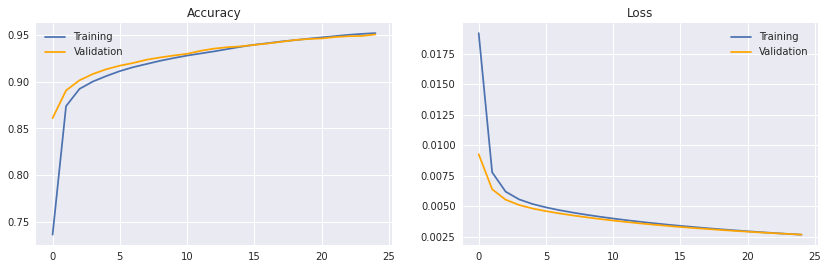

In [19]:
plt.figure(figsize=(14,4), dpi=72)
plt.subplot(121)
plt.plot(history['train_acc'], label='Training')
plt.plot(history['val_acc'], label='Validation', color='orange')
plt.title('Accuracy')
plt.legend()
plt.subplot(122)
plt.plot(history['train_loss'], label='Training')
plt.plot(history['val_loss'], label='Validation', color='orange')
plt.title('Loss')
plt.legend()